In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from collections import Counter

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

# Load the performance data
df = pd.read_csv('performance-results-1751436165155.csv')

print(f"Dataset shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
print(f"Total measurements: {len(df)}")
print(f"Unique functions: {df['name'].nunique()}")
print(f"Date range: {df['duration'].min():.6f}ms to {df['duration'].max():.6f}ms")


Dataset shape: (4127, 4)
Columns: ['name', 'duration', 'path', 'context']
Total measurements: 4127
Unique functions: 8
Date range: 0.000000ms to 0.920208ms


In [36]:
# Basic statistics
print("=== BASIC STATISTICS ===")
print(df.describe())

print("\n=== FUNCTION CALL COUNTS ===")
function_counts = df['name'].value_counts()
print(function_counts)

print("\n=== SAMPLE DATA ===")
print(df.head(10))


=== BASIC STATISTICS ===
          duration
count  4127.000000
mean      0.003045
std       0.038623
min       0.000000
25%       0.000041
50%       0.000042
75%       0.000417
max       0.920208

=== FUNCTION CALL COUNTS ===
name
diff                     2401
deepEqual                1069
diffObject                384
refine                    252
getPlanForPath             10
diffArrayByPrimaryKey       5
diffArray                   5
createPatch                 1
Name: count, dtype: int64

=== SAMPLE DATA ===
             name  duration                           path  \
0  getPlanForPath  0.001875                  /environments   
1  getPlanForPath  0.000042                  /environments   
2       deepEqual  0.005042                            NaN   
3            diff  0.000167             /environments/0/id   
4            diff  0.000000           /environments/0/name   
5            diff  0.000042         /environments/0/region   
6            diff  0.000042  /environments/0/sou

=== TOP 20 SLOWEST INDIVIDUAL CALLS ===
createPatch             0.920ms  nan                                      {"doc1_type":"object","doc2_type":"object"}
diff                    0.919ms  nan                                      {"obj1_type":"object","obj2_type":"object"}
diffObject              0.917ms  nan                                      {"key_count":2}
diff                    0.914ms  /environments                            {"obj1_type":"object","obj2_type":"object"}
diffArray               0.906ms  /environments                            {"arr1_len":5,"arr2_len":5,"strategy":"primaryKey"}
diffArrayByPrimaryKey    0.904ms  /environments                            {"arr1_len":5,"arr2_len":5}
refine                  0.306ms  /environments/0                          {"has_hashFields":true}
diff                    0.306ms  /environments/0                          {"obj1_type":"object","obj2_type":"object"}
diffObject              0.305ms  /environments/0                       

TypeError: object of type 'float' has no len()

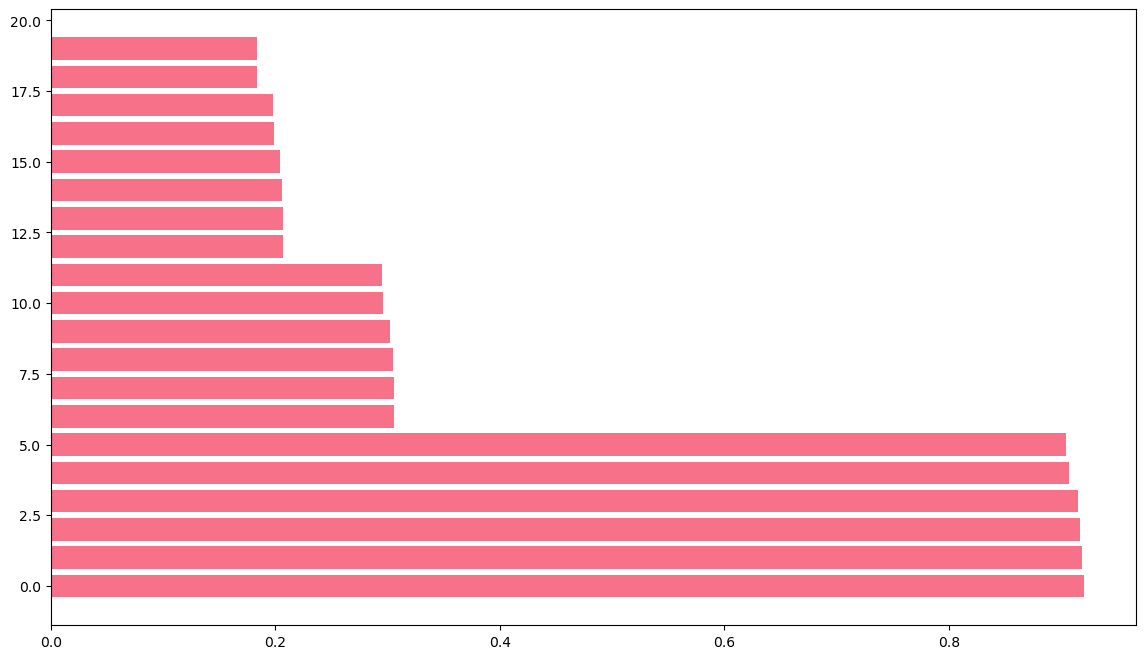

In [37]:
# Top 20 slowest individual function calls
top_slow_calls = df.nlargest(20, 'duration')[['name', 'duration', 'path', 'context']]
print("=== TOP 20 SLOWEST INDIVIDUAL CALLS ===")
for idx, row in top_slow_calls.iterrows():
    context_str = row['context'] if pd.notna(row['context']) else 'N/A'
    print(f"{row['name']:<20} {row['duration']:>8.3f}ms  {row['path']:<40} {context_str}")

# Visualize top slowest calls
plt.figure(figsize=(14, 8))
plt.barh(range(len(top_slow_calls)), top_slow_calls['duration'])
plt.yticks(range(len(top_slow_calls)), 
           [f"{row['name']} ({row['path'][:30]}...)" if len(row['path']) > 30 else f"{row['name']} ({row['path']})" 
            for _, row in top_slow_calls.iterrows()])
plt.xlabel('Duration (ms)')
plt.title('Top 20 Slowest Individual Function Calls')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


=== AGGREGATE PERFORMANCE BY FUNCTION ===
                       count  total_time  mean_time  median_time  std_time  \
name                                                                         
diff                    2401    4.253379   0.001772     0.000042  0.029395   
diffObject               384    2.299286   0.005988     0.001083  0.051875   
diffArray                  5    1.751459   0.350292     0.199041  0.314897   
diffArrayByPrimaryKey      5    1.746292   0.349258     0.198334  0.314152   
refine                   252    1.407581   0.005586     0.001750  0.028062   
createPatch                1    0.920208   0.920208     0.920208       NaN   
deepEqual               1069    0.174290   0.000163     0.000042  0.000479   
getPlanForPath            10    0.013416   0.001342     0.000667  0.001691   

                       min_time  max_time  
name                                       
diff                   0.000000  0.918750  
diffObject             0.000250  0.917000  
d

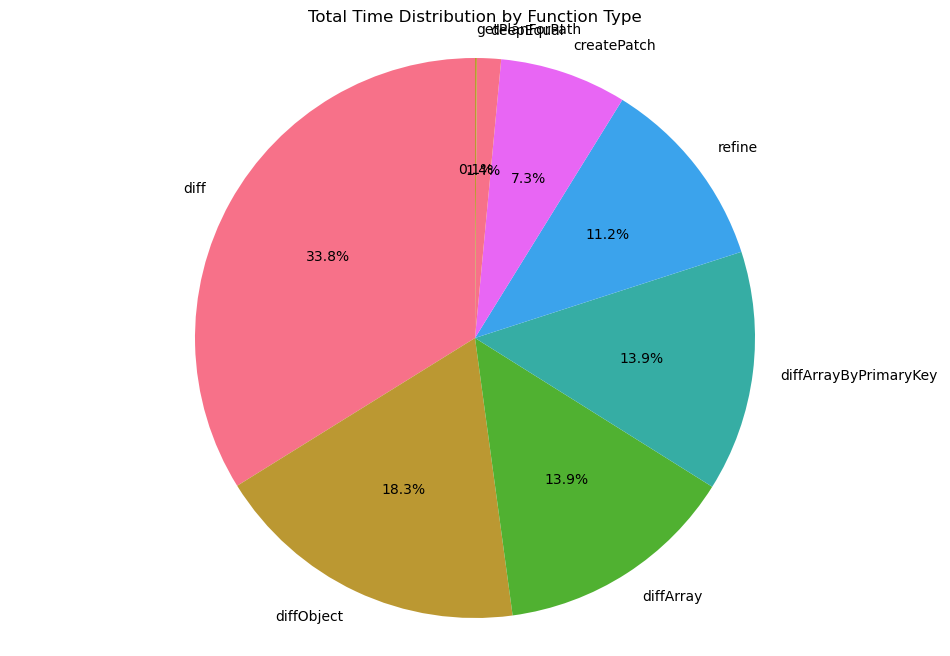

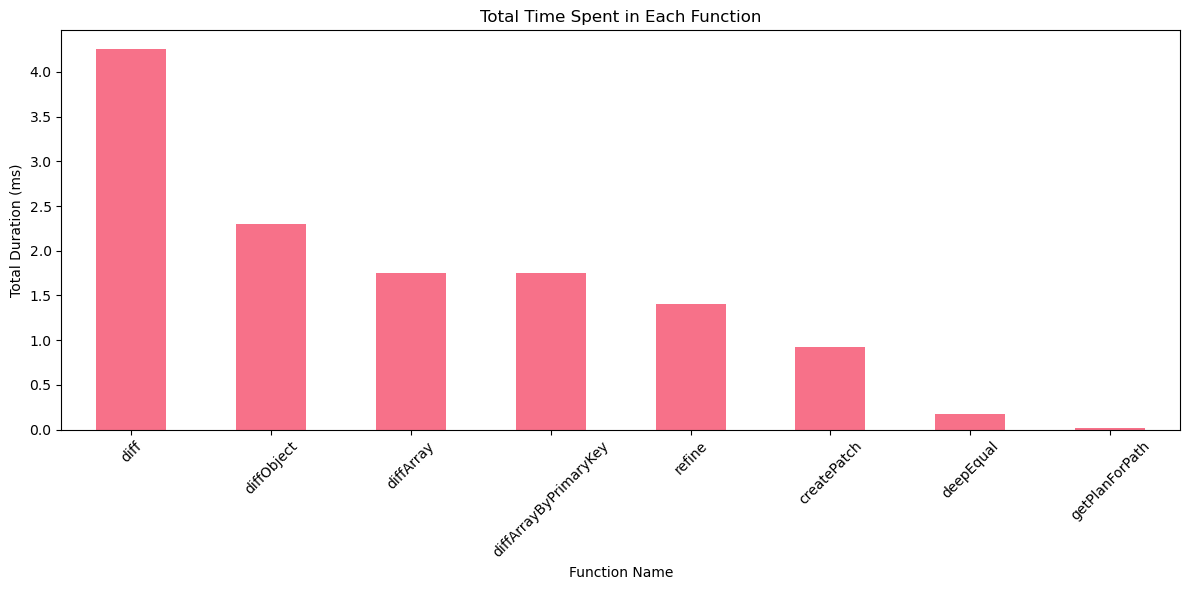

In [38]:
# Aggregate statistics by function name
function_stats = df.groupby('name').agg({
    'duration': ['count', 'sum', 'mean', 'median', 'std', 'min', 'max']
}).round(6)

function_stats.columns = ['count', 'total_time', 'mean_time', 'median_time', 'std_time', 'min_time', 'max_time']
function_stats = function_stats.sort_values('total_time', ascending=False)

print("=== AGGREGATE PERFORMANCE BY FUNCTION ===")
print(function_stats)

# Visualize total time spent in each function
plt.figure(figsize=(12, 8))
plt.pie(function_stats['total_time'], labels=function_stats.index, autopct='%1.1f%%', startangle=90)
plt.title('Total Time Distribution by Function Type')
plt.axis('equal')
plt.show()

# Bar chart of total time
plt.figure(figsize=(12, 6))
function_stats['total_time'].plot(kind='bar')
plt.title('Total Time Spent in Each Function')
plt.ylabel('Total Duration (ms)')
plt.xlabel('Function Name')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


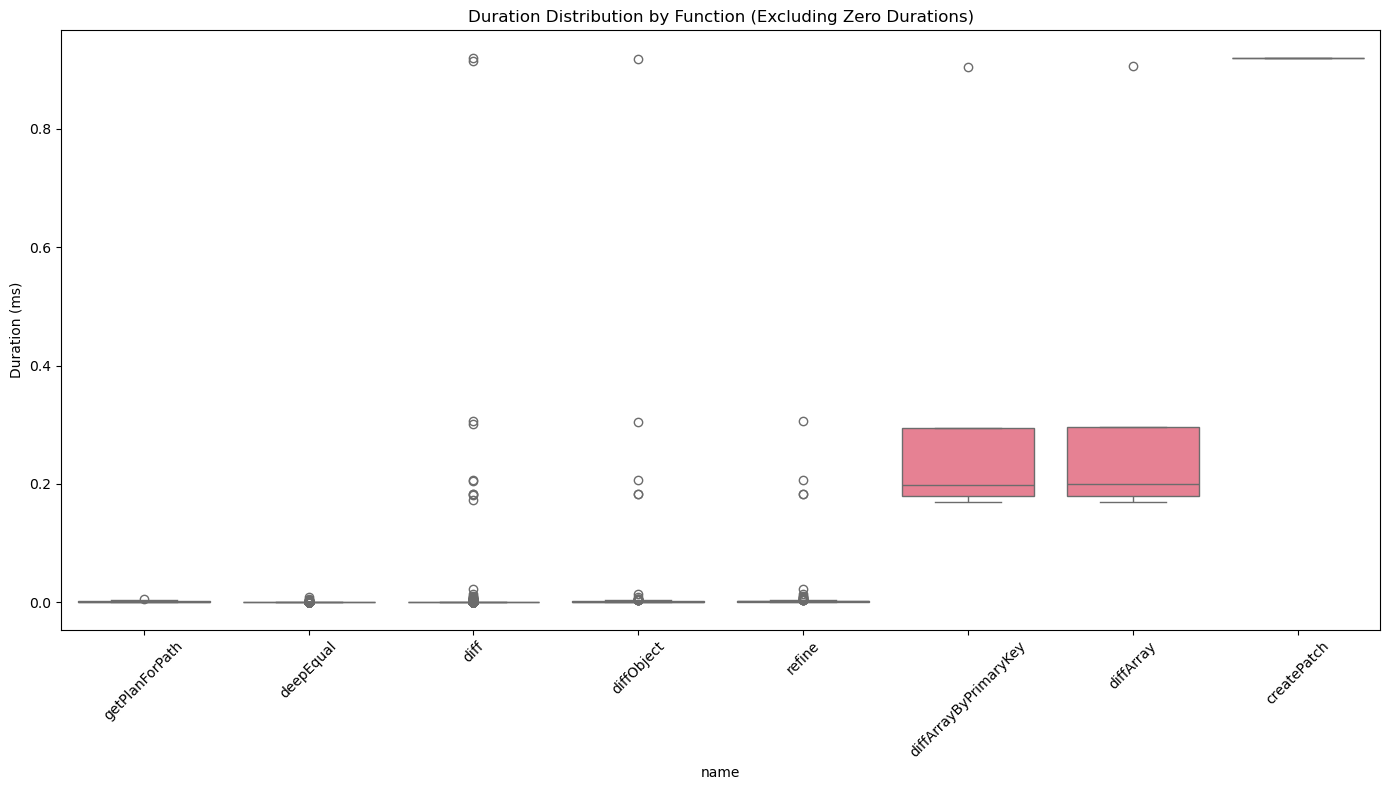

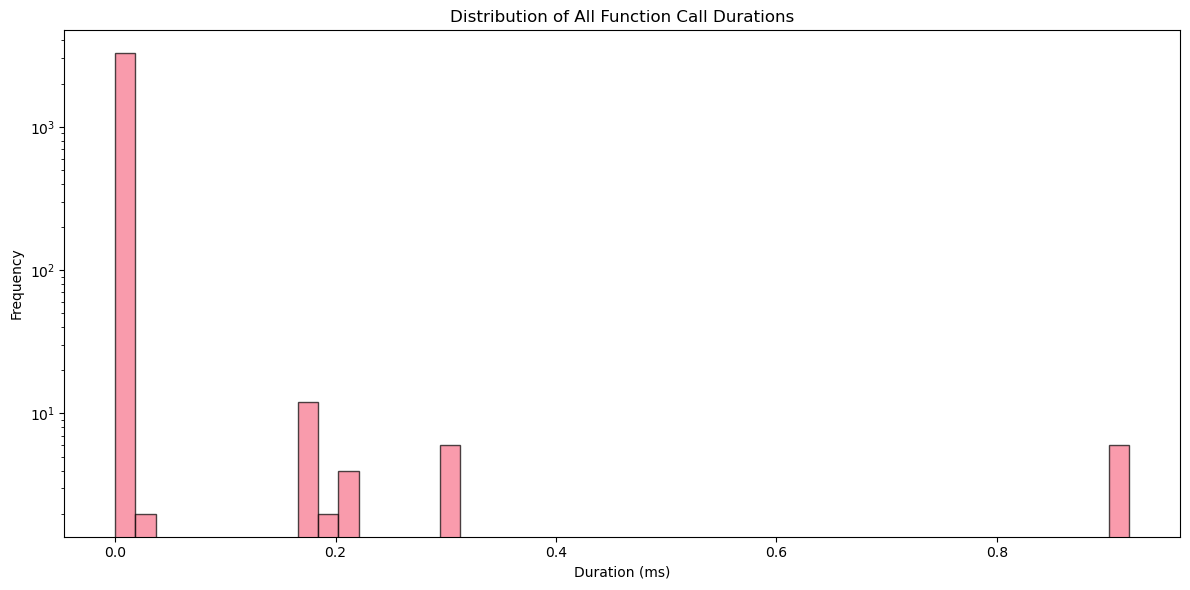

=== DURATION PERCENTILES ===
 50.0th percentile: 0.000042ms
 75.0th percentile: 0.000417ms
 90.0th percentile: 0.001683ms
 95.0th percentile: 0.002321ms
 99.0th percentile: 0.008198ms
 99.9th percentile: 0.906160ms


In [39]:
# Box plot of duration by function
plt.figure(figsize=(14, 8))
df_filtered = df[df['duration'] > 0]  # Remove zero durations for better visualization
sns.boxplot(data=df_filtered, x='name', y='duration')
plt.xticks(rotation=45)
plt.title('Duration Distribution by Function (Excluding Zero Durations)')
plt.ylabel('Duration (ms)')
plt.tight_layout()
plt.show()

# Histogram of all durations
plt.figure(figsize=(12, 6))
plt.hist(df_filtered['duration'], bins=50, alpha=0.7, edgecolor='black')
plt.xlabel('Duration (ms)')
plt.ylabel('Frequency')
plt.title('Distribution of All Function Call Durations')
plt.yscale('log')  # Log scale due to wide range
plt.tight_layout()
plt.show()

# Percentile analysis
print("=== DURATION PERCENTILES ===")
percentiles = [50, 75, 90, 95, 99, 99.9]
for p in percentiles:
    value = np.percentile(df['duration'], p)
    print(f"{p:5.1f}th percentile: {value:8.6f}ms")


=== PERFORMANCE BY PATH DEPTH ===
            count  total_time  mean_time  median_time  max_time
path_depth                                                     
0            1072    2.930248   0.002733     0.000042  0.920208
1               5    2.726876   0.545375     0.904083  0.914417
2              12    2.634042   0.219503     0.194958  0.306125
3              40    2.569377   0.064234     0.000522  0.301958
4             748    1.486405   0.001987     0.001625  0.023208
5            1997    0.207920   0.000104     0.000042  0.003667
6             253    0.011043   0.000044     0.000042  0.001458


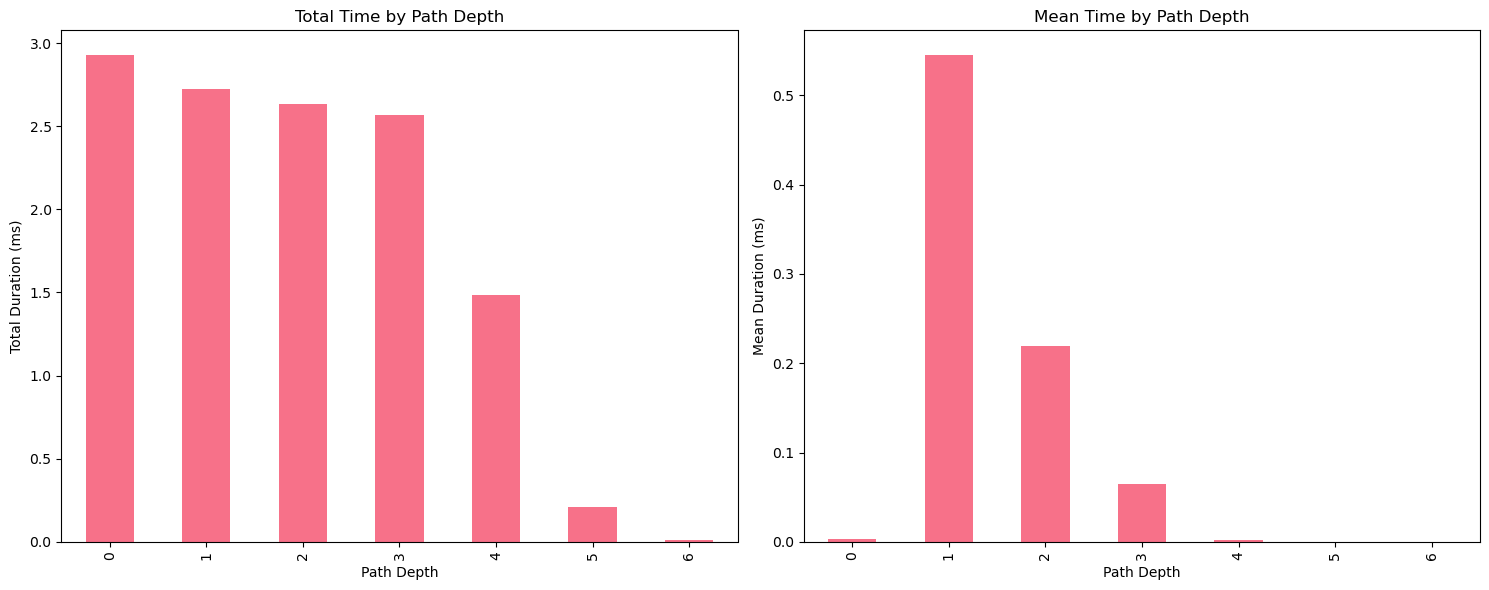

=== TOP 15 MOST EXPENSIVE PATHS ===
                                  sum  count      mean
path                                                  
/environments                2.726876      5  0.545375
/environments/0              0.916959      3  0.305653
/environments/0/services     0.896374      5  0.179275
/environments/3              0.619542      3  0.206514
/environments/3/services     0.606667      5  0.121333
/environments/4              0.550291      3  0.183430
/environments/1              0.547250      3  0.182417
/environments/4/services     0.543251      5  0.108650
/environments/1/services     0.512583      5  0.102517
/environments/0/services/40  0.048208      3  0.016069
/environments/4/services/25  0.041667      3  0.013889
/environments/0/services/14  0.025542      3  0.008514
/environments/0/services/65  0.024666      3  0.008222
/environments/0/services/46  0.022168      3  0.007389
/environments/0/services/0   0.019667      3  0.006556


In [40]:
# Calculate path depth
df['path_depth'] = df['path'].apply(lambda x: len(x.split('/')) - 1 if pd.notna(x) and x else 0)

# Path depth analysis
depth_stats = df.groupby('path_depth').agg({
    'duration': ['count', 'sum', 'mean', 'median', 'max']
}).round(6)
depth_stats.columns = ['count', 'total_time', 'mean_time', 'median_time', 'max_time']

print("=== PERFORMANCE BY PATH DEPTH ===")
print(depth_stats)

# Visualize performance by path depth
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Total time by depth
depth_stats['total_time'].plot(kind='bar', ax=ax1)
ax1.set_title('Total Time by Path Depth')
ax1.set_xlabel('Path Depth')
ax1.set_ylabel('Total Duration (ms)')

# Mean time by depth
depth_stats['mean_time'].plot(kind='bar', ax=ax2)
ax2.set_title('Mean Time by Path Depth')
ax2.set_xlabel('Path Depth')
ax2.set_ylabel('Mean Duration (ms)')

plt.tight_layout()
plt.show()

# Identify most expensive paths
expensive_paths = df.groupby('path')['duration'].agg(['sum', 'count', 'mean']).sort_values('sum', ascending=False).head(15)
print("=== TOP 15 MOST EXPENSIVE PATHS ===")
print(expensive_paths)


=== DIFFARRAY PERFORMANCE BY ARRAY SIZE ===
          count  mean_time  median_time  max_time  total_time
size_bin                                                     
0-10          1   0.906459     0.906459  0.906459    0.906459
11-50         0        NaN          NaN       NaN    0.000000
51-100        0        NaN          NaN       NaN    0.000000
101-500       4   0.211250     0.189687  0.295875    0.845000
500+          0        NaN          NaN       NaN    0.000000


/var/folders/2c/tml4qm151gz7hr0bsbqcgw900000gn/T/ipykernel_68152/2536295385.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  size_analysis = diff_array_calls.groupby('size_bin').agg({


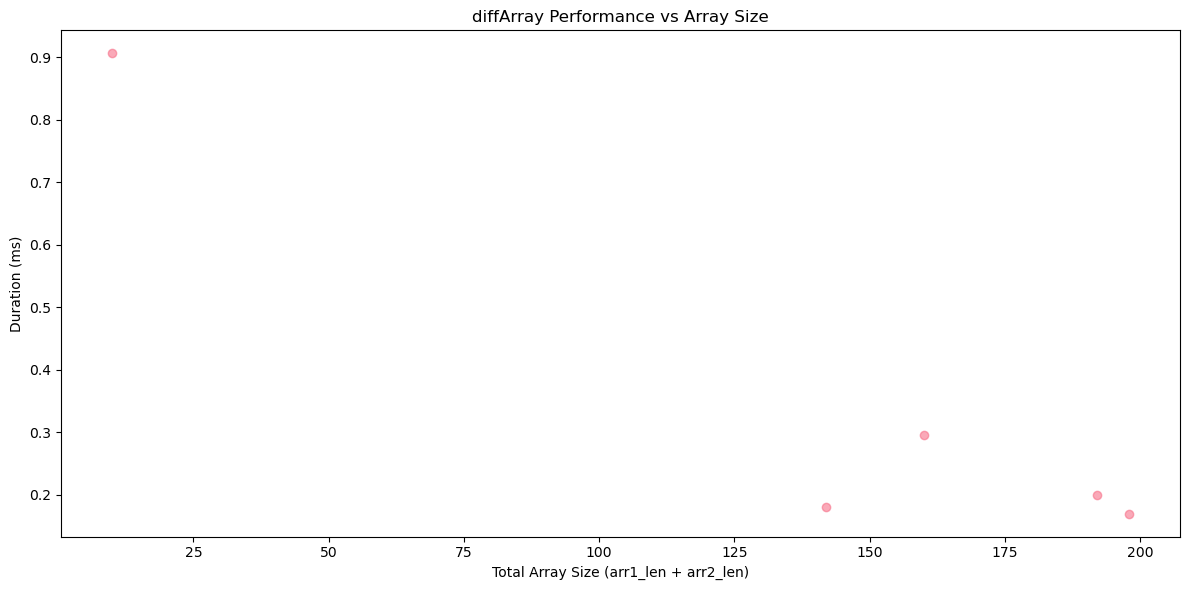


=== DIFFOBJECT PERFORMANCE BY KEY COUNT ===
         count  mean_time  median_time  max_time  total_time
key_bin                                                     
0-5        132   0.007413     0.000375  0.917000    0.978546
6-10         3   0.190639     0.183291  0.206375    0.571916
11-20      248   0.003012     0.001542  0.304750    0.746991
21-50        1   0.001833     0.001833  0.001833    0.001833
50+          0        NaN          NaN       NaN    0.000000


/var/folders/2c/tml4qm151gz7hr0bsbqcgw900000gn/T/ipykernel_68152/2536295385.py:53: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  key_analysis = diff_object_calls.groupby('key_bin').agg({


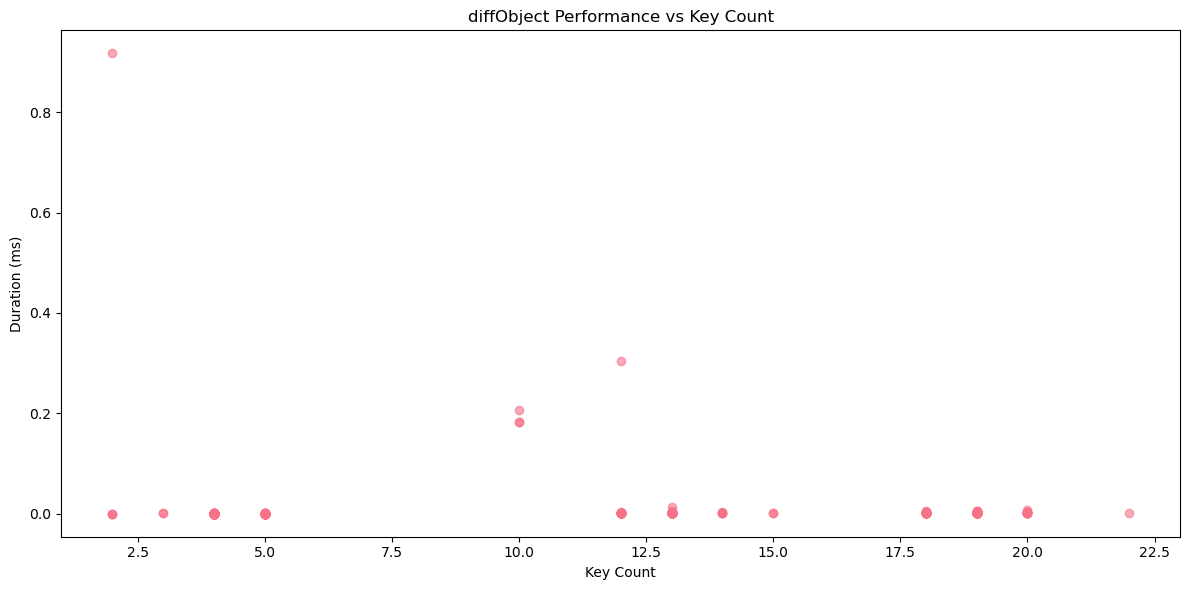

In [41]:
# Parse context information
def parse_context(context_str):
    if pd.isna(context_str) or context_str == '':
        return {}
    try:
        return json.loads(context_str)
    except:
        return {}

df['context_parsed'] = df['context'].apply(parse_context)

# Extract array length information for diffArray calls
diff_array_calls = df[df['name'] == 'diffArray'].copy()
diff_array_calls['arr1_len'] = diff_array_calls['context_parsed'].apply(lambda x: x.get('arr1_len', 0))
diff_array_calls['arr2_len'] = diff_array_calls['context_parsed'].apply(lambda x: x.get('arr2_len', 0))
diff_array_calls['total_array_size'] = diff_array_calls['arr1_len'] + diff_array_calls['arr2_len']

if len(diff_array_calls) > 0:
    print("=== DIFFARRAY PERFORMANCE BY ARRAY SIZE ===")
    
    # Bin array sizes for analysis
    diff_array_calls['size_bin'] = pd.cut(diff_array_calls['total_array_size'], 
                                         bins=[0, 10, 50, 100, 500, float('inf')], 
                                         labels=['0-10', '11-50', '51-100', '101-500', '500+'])
    
    size_analysis = diff_array_calls.groupby('size_bin').agg({
        'duration': ['count', 'mean', 'median', 'max', 'sum']
    }).round(6)
    size_analysis.columns = ['count', 'mean_time', 'median_time', 'max_time', 'total_time']
    print(size_analysis)
    
    # Scatter plot of array size vs duration
    plt.figure(figsize=(12, 6))
    plt.scatter(diff_array_calls['total_array_size'], diff_array_calls['duration'], alpha=0.6)
    plt.xlabel('Total Array Size (arr1_len + arr2_len)')
    plt.ylabel('Duration (ms)')
    plt.title('diffArray Performance vs Array Size')
    plt.tight_layout()
    plt.show()

# Analyze object diffing performance
diff_object_calls = df[df['name'] == 'diffObject'].copy()
diff_object_calls['key_count'] = diff_object_calls['context_parsed'].apply(lambda x: x.get('key_count', 0))

if len(diff_object_calls) > 0:
    print("\n=== DIFFOBJECT PERFORMANCE BY KEY COUNT ===")
    
    # Bin key counts
    diff_object_calls['key_bin'] = pd.cut(diff_object_calls['key_count'], 
                                         bins=[0, 5, 10, 20, 50, float('inf')], 
                                         labels=['0-5', '6-10', '11-20', '21-50', '50+'])
    
    key_analysis = diff_object_calls.groupby('key_bin').agg({
        'duration': ['count', 'mean', 'median', 'max', 'sum']
    }).round(6)
    key_analysis.columns = ['count', 'mean_time', 'median_time', 'max_time', 'total_time']
    print(key_analysis)
    
    # Scatter plot of key count vs duration
    plt.figure(figsize=(12, 6))
    plt.scatter(diff_object_calls['key_count'], diff_object_calls['duration'], alpha=0.6)
    plt.xlabel('Key Count')
    plt.ylabel('Duration (ms)')
    plt.title('diffObject Performance vs Key Count')
    plt.tight_layout()
    plt.show()


In [43]:
# Generate optimization recommendations
print("=== OPTIMIZATION RECOMMENDATIONS ===\n")

# 1. Function-level hotspots
print("1. FUNCTION-LEVEL HOTSPOTS:")
for func_name, stats in function_stats.head(3).iterrows():
    total_time = stats['total_time']
    call_count = stats['count']
    mean_time = stats['mean_time']
    percentage = (total_time / function_stats['total_time'].sum()) * 100
    print(f"   • {func_name}: {total_time:.3f}ms total ({percentage:.1f}% of total time)")
    print(f"     - {call_count} calls, {mean_time:.6f}ms average")
    if mean_time > 0.1:
        print(f"     - HIGH PRIORITY: Average call time > 0.1ms")
    print()

# 2. Path-based recommendations
print("2. PATH-BASED OPTIMIZATION:")
for path, stats in expensive_paths.head(5).iterrows():
    total_time = stats['sum']
    call_count = stats['count']
    mean_time = stats['mean']
    print(f"   • {path}: {total_time:.3f}ms total, {call_count} calls, {mean_time:.6f}ms avg")

# 3. Array size impact
if len(diff_array_calls) > 0:
    print("\n3. ARRAY DIFFING OPTIMIZATION:")
    large_arrays = diff_array_calls[diff_array_calls['total_array_size'] > 100]
    if len(large_arrays) > 0:
        avg_time_large = large_arrays['duration'].mean()
        print(f"   • Large arrays (>100 elements): {len(large_arrays)} calls, {avg_time_large:.6f}ms average")
        print(f"   • Consider optimizing array diffing algorithms for large datasets")

# 4. Object key count impact
if len(diff_object_calls) > 0:
    print("\n4. OBJECT DIFFING OPTIMIZATION:")
    large_objects = diff_object_calls[diff_object_calls['key_count'] > 20]
    if len(large_objects) > 0:
        avg_time_large_obj = large_objects['duration'].mean()
        print(f"   • Large objects (>20 keys): {len(large_objects)} calls, {avg_time_large_obj:.6f}ms average")
        print(f"   • Consider optimizing object key iteration for complex objects")

# 5. Zero duration analysis
zero_duration_calls = df[df['duration'] == 0]
print(f"\n5. ZERO DURATION CALLS:")
print(f"   • {len(zero_duration_calls)} calls with zero duration ({len(zero_duration_calls)/len(df)*100:.1f}% of total)")
print(f"   • These may indicate very fast operations or measurement precision issues")

# 6. Summary statistics
print(f"\n6. SUMMARY STATISTICS:")
print(f"   • Total execution time: {df['duration'].sum():.3f}ms")
print(f"   • Total function calls: {len(df)}")
print(f"   • Average call time: {df['duration'].mean():.6f}ms")
print(f"   • Median call time: {df['duration'].median():.6f}ms")
print(f"   • 95th percentile: {np.percentile(df['duration'], 95):.6f}ms")


=== OPTIMIZATION RECOMMENDATIONS ===

1. FUNCTION-LEVEL HOTSPOTS:
   • diff: 4.253ms total (33.8% of total time)
     - 2401.0 calls, 0.001772ms average

   • diffObject: 2.299ms total (18.3% of total time)
     - 384.0 calls, 0.005988ms average

   • diffArray: 1.751ms total (13.9% of total time)
     - 5.0 calls, 0.350292ms average
     - HIGH PRIORITY: Average call time > 0.1ms

2. PATH-BASED OPTIMIZATION:
   • /environments: 2.727ms total, 5.0 calls, 0.545375ms avg
   • /environments/0: 0.917ms total, 3.0 calls, 0.305653ms avg
   • /environments/0/services: 0.896ms total, 5.0 calls, 0.179275ms avg
   • /environments/3: 0.620ms total, 3.0 calls, 0.206514ms avg
   • /environments/3/services: 0.607ms total, 5.0 calls, 0.121333ms avg

3. ARRAY DIFFING OPTIMIZATION:
   • Large arrays (>100 elements): 4 calls, 0.211250ms average
   • Consider optimizing array diffing algorithms for large datasets

4. OBJECT DIFFING OPTIMIZATION:
   • Large objects (>20 keys): 1 calls, 0.001833ms average


In [25]:
# Create summary report
summary_report = {
    'total_execution_time_ms': df['duration'].sum(),
    'total_function_calls': len(df),
    'unique_functions': df['name'].nunique(),
    'avg_call_time_ms': df['duration'].mean(),
    'median_call_time_ms': df['duration'].median(),
    'p95_call_time_ms': np.percentile(df['duration'], 95),
    'p99_call_time_ms': np.percentile(df['duration'], 99),
    'slowest_single_call_ms': df['duration'].max(),
    'zero_duration_calls': len(zero_duration_calls),
    'zero_duration_percentage': len(zero_duration_calls) / len(df) * 100
}

# Save function statistics
function_stats.to_csv('function_performance_summary.csv')

# Save top expensive paths
expensive_paths.to_csv('expensive_paths_summary.csv')

# Save summary report
import json
with open('performance_summary_report.json', 'w') as f:
    json.dump(summary_report, f, indent=2)

print("=== EXPORTED FILES ===")
print("• function_performance_summary.csv - Aggregate stats by function")
print("• expensive_paths_summary.csv - Most expensive paths")
print("• performance_summary_report.json - Overall summary statistics")

print(f"\n=== FINAL SUMMARY ===")
print(f"Total execution time: {summary_report['total_execution_time_ms']:.3f}ms")
print(f"Most expensive function: {function_stats.index[0]} ({function_stats.iloc[0]['total_time']:.3f}ms total)")
print(f"Slowest single call: {summary_report['slowest_single_call_ms']:.6f}ms")
print(f"Functions to optimize (top 3): {', '.join(function_stats.head(3).index.tolist())}")


=== EXPORTED FILES ===
• function_performance_summary.csv - Aggregate stats by function
• expensive_paths_summary.csv - Most expensive paths
• performance_summary_report.json - Overall summary statistics

=== FINAL SUMMARY ===
Total execution time: 26.548ms
Most expensive function: diff (8.826ms total)
Slowest single call: 2.206625ms
Functions to optimize (top 3): diff, diffObject, diffArray
